Total images:  208999
Train: 167199, Val: 20899, Test: 20901


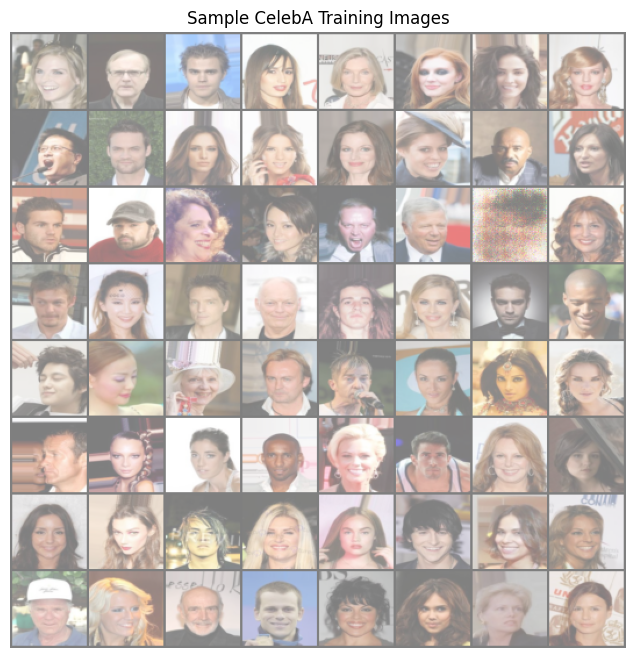

In [ ]:
# ======================
# Part 1: Data Preparation
# ======================
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils

# Set random seeds for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Define image transformations: resize to 64x64, convert to tensor, and normalize to [-1,1]
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Assume the folder with CelebA images is provided. Adjust the path if needed.
data_path = "/Users/Vignesh/Desktop/courseWork/dl/ass7"
dataset = ImageFolder(root=data_path, transform=transform)

print("Total images: ", len(dataset))

# Split dataset: 80% training, 10% validation, 10% testing.
n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val

train_dataset, val_dataset, test_dataset = random_split(dataset, [n_train, n_val, n_test])
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# Visualize a few examples from the training set
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    plt.axis('off')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
dataiter = iter(train_loader)
images, _ = next(dataiter)
plt.figure(figsize=(8,8))
imshow(vutils.make_grid(images[:64], padding=2, normalize=True))
plt.title("Sample CelebA Training Images")
plt.show()


Using device: cpu
Starting WGAN Training...
Epoch 1/2 completed.
Epoch 2/2 completed.


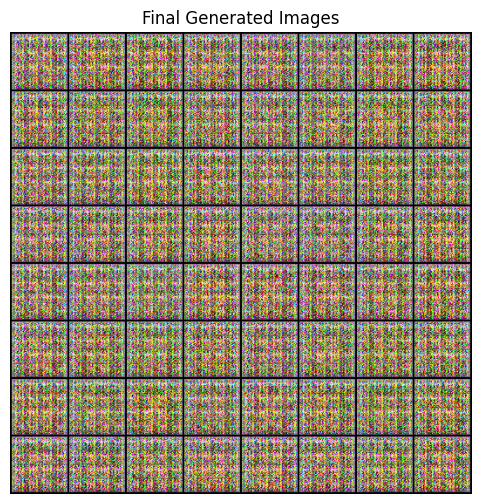

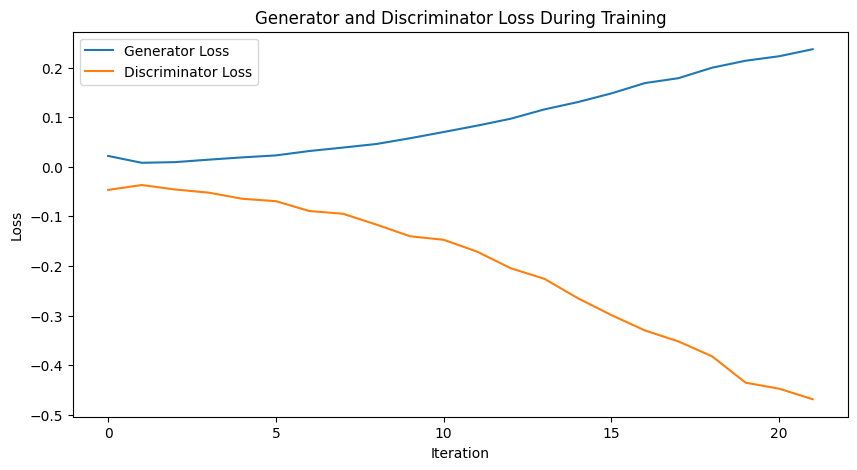

In [ ]:
# ======================
# Part 2: WGAN Implementation for Synthetic Data Generation
# ======================

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Hyperparameters for WGAN
nz = 100       # latent vector size
ngf = 64       # feature maps in generator
ndf = 64       # feature maps in discriminator
nc = 3         # number of channels (RGB)
num_epochs = 2  # reduced for fast testing; increase for better training
lr = 0.00005   # learning rate for RMSProp
clip_value = 0.01
n_critic = 5   # number of discriminator (critic) updates per generator update
batch_size = 64

# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: latent vector Z of shape (nz, 1, 1)
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()  # Output is in range [-1,1]
            # Final output: (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Discriminator Model (Critic)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
            # Output: scalar (no sigmoid in WGAN)
        )

    def forward(self, input):
        return self.main(input).view(-1)

# Initialize models and optimizers
netG = Generator().to(device)
netD = Discriminator().to(device)
optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

# Loss tracking lists
G_losses = []
D_losses = []

# Create DataLoader for training
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Starting WGAN Training...")
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size_curr = real_images.size(0)
        
        # Train Discriminator (critic) for n_critic iterations
        for _ in range(n_critic):
            optimizerD.zero_grad()
            noise = torch.randn(batch_size_curr, nz, 1, 1, device=device)
            fake_images = netG(noise).detach()  # Detach to avoid gradients flowing into G
            loss_D = -torch.mean(netD(real_images)) + torch.mean(netD(fake_images))
            loss_D.backward()
            optimizerD.step()
            # Weight clipping for Lipschitz constraint
            for p in netD.parameters():
                p.data.clamp_(-clip_value, clip_value)
                
        # Train Generator
        optimizerG.zero_grad()
        noise = torch.randn(batch_size_curr, nz, 1, 1, device=device)
        fake_images = netG(noise)
        loss_G = -torch.mean(netD(fake_images))
        loss_G.backward()
        optimizerG.step()
        
        # Save losses for analysis
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        
        # Optionally, break after 100 iterations per epoch to speed up training
        if i >= 100:
            break

    print(f"Epoch {epoch+1}/{num_epochs} completed.")

# Generate final sample images for evaluation
netG.eval()
with torch.no_grad():
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    fake = netG(fixed_noise).detach().cpu()

plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("Final Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True).cpu(), (1,2,0)))
plt.show()

# Plot the training losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
import os
import torch.nn.functional as F
from torchvision import models
import numpy as np
from scipy.stats import entropy

# ----------------------
# Inception Score (IS) Evaluation
# ----------------------
def compute_inception_score(generator, num_images=500, batch_size=64, device="cuda"):
    """
    Computes the Inception Score (IS) on generated images.
    Here, num_images is reduced for fast evaluation.
    """
    generator.eval()
    # Load pretrained InceptionV3 model with aux_logits=True
    inception_model = models.inception_v3(pretrained=True, transform_input=False, aux_logits=True).to(device)
    inception_model.eval()

    preds = []
    num_batches = num_images // batch_size
    with torch.no_grad():
        for i in range(num_batches):
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = generator(noise)
            # Rescale from [-1, 1] to [0, 1]
            fake_images = (fake_images + 1) / 2.0
            # Upsample to 299x299 (InceptionV3 input size)
            fake_images = F.interpolate(fake_images, size=(299, 299), mode='bilinear', align_corners=False)
            # Forward pass through InceptionV3 (extract primary output)
            outputs = inception_model(fake_images)
            primary_output = outputs[0] if isinstance(outputs, tuple) else outputs
            preds_batch = F.softmax(primary_output, dim=1).cpu().numpy()
            preds.append(preds_batch)
    
    preds = np.concatenate(preds, axis=0)
    split_scores = []
    splits = 10
    n_part = preds.shape[0] // splits
    for i in range(splits):
        part = preds[i * n_part : (i + 1) * n_part]
        py = np.mean(part, axis=0)
        scores = [entropy(p, py) for p in part]
        split_scores.append(np.exp(np.mean(scores)))
    
    is_score = np.mean(split_scores)
    print(f"Inception Score (IS): {is_score:.4f}")
    return is_score

# Evaluate IS using 500 images for faster computation
compute_inception_score(netG, num_images=500, batch_size=batch_size, device=device)


# ----------------------
# Fréchet Inception Distance (FID) Evaluation
# ----------------------
from pytorch_fid import fid_score
import torchvision.utils as vutils

def save_generated_images(generator, save_path="generated_images", num_images=500, batch_size=64):
    """
    Saves a subset of generated images for FID computation.
    """
    os.makedirs(save_path, exist_ok=True)
    generator.eval()
    num_batches = num_images // batch_size
    with torch.no_grad():
        for i in range(num_batches):
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = generator(noise).cpu()
            for j, img in enumerate(fake_images):
                vutils.save_image(img, os.path.join(save_path, f"img_{i * batch_size + j}.png"), normalize=True)

# Save generated images (using 500 images)
save_generated_images(netG, save_path="generated_images", num_images=500, batch_size=batch_size)

# Create a subset folder for real images (using 500 images)
real_images_path = "./img_align_celeba"  # Your real images folder
real_subset_path = "./real_subset"
os.makedirs(real_subset_path, exist_ok=True)
real_files = sorted([f for f in os.listdir(real_images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
# Copy the first 500 real images to the subset folder
import shutil
num_real_subset = 500
for f in real_files[:num_real_subset]:
    src = os.path.join(real_images_path, f)
    dst = os.path.join(real_subset_path, f)
    if not os.path.exists(dst):
        shutil.copy(src, dst)

print("Number of generated images found:", len(os.listdir("generated_images")))
print("Number of real images in subset:", len(os.listdir(real_subset_path)))

# Compute FID using the generated images and the real subset
fid_value = fid_score.calculate_fid_given_paths(
    [real_subset_path, "./generated_images"],
    batch_size=batch_size,
    device=device,
    dims=2048
)
print(f"Fréchet Inception Distance (FID): {fid_value:.4f}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception Score (IS): 1.1093
Number of generated images found: 6400
Number of real images in subset: 500


100%|██████████| 100/100 [14:17<00:00,  8.58s/it]


Fréchet Inception Distance (FID): 331.4798



Tuning with lr=5e-05, batch_size=32, nz=100
Tuning epoch 1/1 complete.


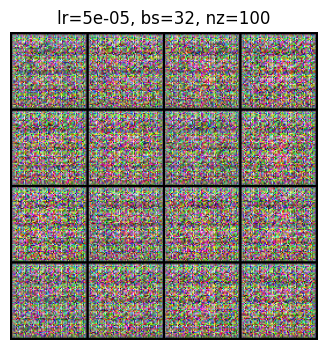


Tuning with lr=5e-05, batch_size=32, nz=128
Tuning epoch 1/1 complete.


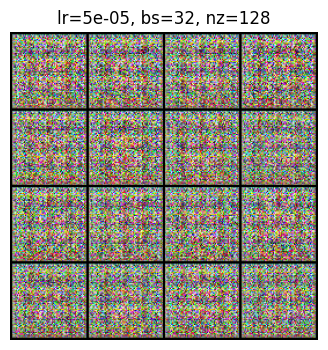


Tuning with lr=5e-05, batch_size=64, nz=100
Tuning epoch 1/1 complete.


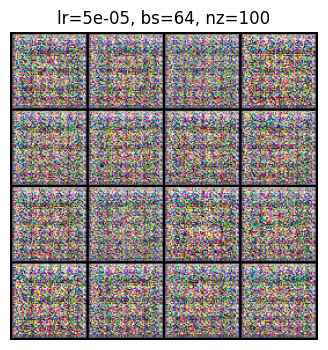


Tuning with lr=5e-05, batch_size=64, nz=128
Tuning epoch 1/1 complete.


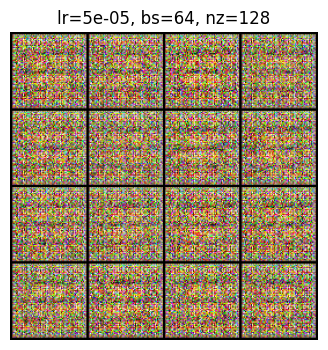


Tuning with lr=0.0001, batch_size=32, nz=100
Tuning epoch 1/1 complete.


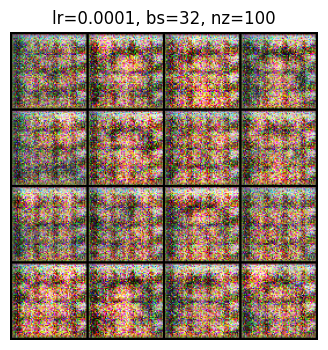


Tuning with lr=0.0001, batch_size=32, nz=128
Tuning epoch 1/1 complete.


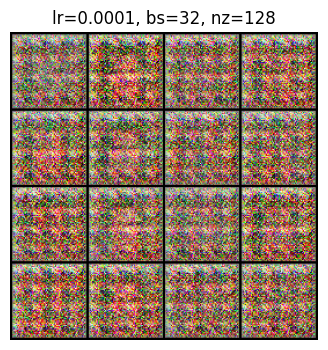


Tuning with lr=0.0001, batch_size=64, nz=100
Tuning epoch 1/1 complete.


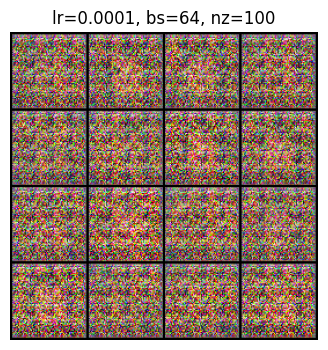


Tuning with lr=0.0001, batch_size=64, nz=128
Tuning epoch 1/1 complete.


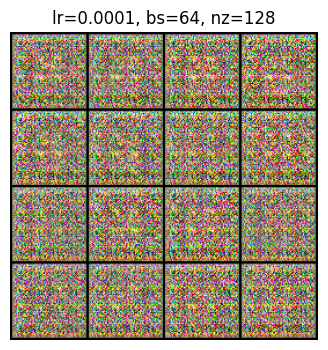

        lr  batch_size   nz    loss_G    loss_D
0  0.00005          32  100  0.240943 -0.487251
1  0.00005          32  128  0.217426 -0.470042
2  0.00005          64  100  0.134808 -0.270232
3  0.00005          64  128  0.178293 -0.333376
4  0.00010          32  100  0.410463 -0.796641
5  0.00010          32  128  0.388188 -0.762914
6  0.00010          64  100  0.366667 -0.724409
7  0.00010          64  128  0.387655 -0.769053


In [17]:
# ======================
# Part 3: Hyperparameter Tuning and Optimization
# ======================
import itertools
import matplotlib.pyplot as plt

# Define a small grid of hyperparameters to experiment with
param_grid = {
    "lr": [0.00005, 0.0001],
    "batch_size": [32, 64],      # use smaller batch sizes for speed
    "nz": [100, 128]             # latent vector sizes
}

# Store tuning results (and sample images for qualitative comparison)
tuning_results = []

# Use only a subset of the training data for fast tuning
subset_size = 1000
tuning_dataset, _ = random_split(train_dataset, [subset_size, len(train_dataset) - subset_size])

for lr_val, batch_size_val, nz_val in itertools.product(param_grid["lr"], param_grid["batch_size"], param_grid["nz"]):
    print(f"\nTuning with lr={lr_val}, batch_size={batch_size_val}, nz={nz_val}")

    # Redefine hyperparameters
    current_nz = nz_val
    
    # Redefine Generator and Discriminator with current nz
    class GeneratorTuned(nn.Module):
        def __init__(self):
            super(GeneratorTuned, self).__init__()
            self.main = nn.Sequential(
                nn.ConvTranspose2d(current_nz, ngf * 8, 4, 1, 0, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.ReLU(True),
                nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * 4),
                nn.ReLU(True),
                nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * 2),
                nn.ReLU(True),
                nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf),
                nn.ReLU(True),
                nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
                nn.Tanh()
            )
        def forward(self, input):
            return self.main(input)
    
    class DiscriminatorTuned(nn.Module):
        def __init__(self):
            super(DiscriminatorTuned, self).__init__()
            self.main = nn.Sequential(
                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
            )
        def forward(self, input):
            return self.main(input).view(-1)
    
    # Initialize tuned models and optimizers
    netG_tuned = GeneratorTuned().to(device)
    netD_tuned = DiscriminatorTuned().to(device)
    optimizerD_tuned = optim.RMSprop(netD_tuned.parameters(), lr=lr_val)
    optimizerG_tuned = optim.RMSprop(netG_tuned.parameters(), lr=lr_val)
    
    # DataLoader for tuning
    tuning_loader = DataLoader(tuning_dataset, batch_size=batch_size_val, shuffle=True)
    
    # Train for only 1 epoch for fast tuning
    num_epochs_tune = 1
    for epoch in range(num_epochs_tune):
        for i, (real_images, _) in enumerate(tuning_loader):
            real_images = real_images.to(device)
            current_bs = real_images.size(0)
            
            # Train discriminator n_critic times
            for _ in range(n_critic):
                optimizerD_tuned.zero_grad()
                noise = torch.randn(current_bs, current_nz, 1, 1, device=device)
                fake_images = netG_tuned(noise).detach()
                loss_D = -torch.mean(netD_tuned(real_images)) + torch.mean(netD_tuned(fake_images))
                loss_D.backward()
                optimizerD_tuned.step()
                for p in netD_tuned.parameters():
                    p.data.clamp_(-clip_value, clip_value)
                    
            # Train generator
            optimizerG_tuned.zero_grad()
            noise = torch.randn(current_bs, current_nz, 1, 1, device=device)
            fake_images = netG_tuned(noise)
            loss_G = -torch.mean(netD_tuned(fake_images))
            loss_G.backward()
            optimizerG_tuned.step()
            
            # Break early to speed up tuning
            if i >= 20:
                break
        print(f"Tuning epoch {epoch+1}/{num_epochs_tune} complete.")

    # Generate a small batch of images to visualize quality
    netG_tuned.eval()
    with torch.no_grad():
        fixed_noise = torch.randn(16, current_nz, 1, 1, device=device)
        tuned_samples = netG_tuned(fixed_noise).detach().cpu()
    grid = vutils.make_grid(tuned_samples, nrow=4, padding=2, normalize=True)
    plt.figure(figsize=(4,4))
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.title(f"lr={lr_val}, bs={batch_size_val}, nz={current_nz}")
    plt.axis("off")
    plt.show()

    tuning_results.append({
        "lr": lr_val,
        "batch_size": batch_size_val,
        "nz": current_nz,
        "loss_G": loss_G.item(),
        "loss_D": loss_D.item()
    })

# Show summary of tuning results
import pandas as pd
df_tuning = pd.DataFrame(tuning_results)
print(df_tuning)


In [28]:
# ======================
# Part 4: Train a Classifier on Real Data
# ======================
import pandas as pd
from torch.utils.data import Subset

# Custom Dataset for CelebA with attributes
class CelebAWithAttributes(Dataset):
    def __init__(self, img_dir, attr_file, transform=None, indices=None):
        self.img_dir = img_dir
        self.transform = transform
        
        # Load attribute file; assumes whitespace separated and header in first row
        self.attr_df = pd.read_csv(attr_file, delim_whitespace=True, skiprows=1)
        # Rename first column to "filename" if needed (here we use index as filename)
        # Convert the "Young" attribute from {-1, 1} to {0, 1}
        self.attr_df['Young'] = self.attr_df['Young'].apply(lambda x: 1 if x == 1 else 0)
        
        if indices is not None:
            self.attr_df = self.attr_df.iloc[indices]
        
        self.filenames = list(self.attr_df.index)
    
    def __len__(self):
        return len(self.attr_df)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]  # Use filename directly
        img_path = os.path.join(self.img_dir, "img_align_celeba", filename) 

        if not os.path.exists(img_path):  
            print(f"Warning: Missing file {img_path}")  # Debugging step

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label = self.attr_df.iloc[idx]['Young']
        return image, label


# Define transformation same as before
transform_cls = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

attr_file = "./list_attr_celeba.txt"  # update if necessary
full_dataset_attr = CelebAWithAttributes(img_dir=data_path, attr_file=attr_file, transform=transform_cls)

# Split dataset into training, validation, test (use 2000 samples for fast training)
n_total_attr = len(full_dataset_attr)
n_train_attr = int(0.8 * n_total_attr)
n_val_attr = int(0.1 * n_total_attr)
n_test_attr = n_total_attr - n_train_attr - n_val_attr

train_dataset_attr, val_dataset_attr, test_dataset_attr = random_split(full_dataset_attr, [n_train_attr, n_val_attr, n_test_attr])

# For fast execution, select a small subset (e.g., 2000 samples) from training set
train_dataset_attr = Subset(train_dataset_attr, list(range(2000)))
val_dataset_attr = Subset(val_dataset_attr, list(range(min(500, len(val_dataset_attr)))))  # up to 500 for validation

train_loader_attr = DataLoader(train_dataset_attr, batch_size=64, shuffle=True)
val_loader_attr = DataLoader(val_dataset_attr, batch_size=64, shuffle=False)

# Define a simple CNN for binary classification
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 32 x 32 x 32
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # 64 x 16 x 16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 128 x 8 x 8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 256 x 4 x 4
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256*4*4, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

netC = SimpleCNN().to(device)
criterion = nn.BCELoss()
optimizerC = optim.Adam(netC.parameters(), lr=0.0002)

# Train the classifier for a few epochs
num_epochs_cls = 3  # few epochs for fast testing
for epoch in range(num_epochs_cls):
    netC.train()
    running_loss = 0.0
    for images, labels in train_loader_attr:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        optimizerC.zero_grad()
        outputs = netC(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizerC.step()
        running_loss += loss.item()
    # Validate after each epoch
    netC.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader_attr:
            images, labels = images.to(device), labels.to(device)
            outputs = netC(images)
            preds = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (preds.squeeze() == labels.float()).sum().item()
    print(f"Epoch [{epoch+1}/{num_epochs_cls}], Loss: {running_loss/len(train_loader_attr):.4f}, Val Acc: {correct/total:.4f}")


/var/folders/x4/vrbpmvn97nd_sp01bnx3yz1c0000gn/T/ipykernel_7712/3274270293.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.attr_df = pd.read_csv(attr_file, delim_whitespace=True, skiprows=1)


Epoch [1/3], Loss: 0.5070, Val Acc: 0.7860
Epoch [2/3], Loss: 0.3985, Val Acc: 0.7900
Epoch [3/3], Loss: 0.3162, Val Acc: 0.8040


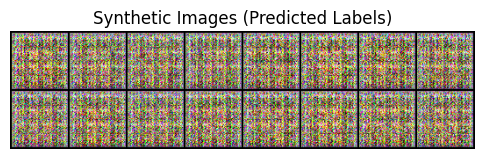

Sample predicted labels for synthetic images:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [32]:
num_synthetic = int(0.5 * len(train_dataset))  

small_batch_size = batch_size 

synthetic_images = []
synthetic_labels = []

netG.eval()
netC.eval()
with torch.no_grad():
    for _ in range(num_synthetic // small_batch_size + 1):
        noise = torch.randn(small_batch_size, nz, 1, 1, device=device)
        fake_imgs = netG(noise)
        outputs = netC(fake_imgs)
        preds = (outputs > 0.5).float()
        synthetic_images.append(fake_imgs.cpu())
        synthetic_labels.append(preds.cpu())

# Reduce the number of images processed
synthetic_images = torch.cat(synthetic_images, dim=0)[:num_synthetic]
synthetic_labels = torch.cat(synthetic_labels, dim=0)[:num_synthetic]

# Reduce visualization to 16 images instead of 64
grid = vutils.make_grid(synthetic_images[:16], padding=2, normalize=True)
plt.figure(figsize=(6,6))  # Smaller figure size
plt.imshow(np.transpose(grid, (1,2,0)))
plt.title("Synthetic Images (Predicted Labels)")
plt.axis("off")
plt.show()

# Print fewer labels for quick inspection
print("Sample predicted labels for synthetic images:")
print(synthetic_labels[:10].squeeze().numpy()) 


In [33]:
# ======================
# Part 6: Train a Classifier on Real Data + Synthetic Data
# ======================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# For the real data, take a subset (for fast execution)
n_real = int(0.3 * len(train_dataset_attr))
real_subset = Subset(train_dataset_attr, list(range(n_real)))

# Create a dataset for synthetic samples
class SyntheticDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return self.images.size(0)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx].item()
        if self.transform:
            img = self.transform(img)
        return img, label

synthetic_dataset = SyntheticDataset(synthetic_images, synthetic_labels, transform=None)

# Combine datasets: 70% synthetic and 30% real
combined_dataset = torch.utils.data.ConcatDataset([synthetic_dataset, real_subset])
combined_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True)

# Define a new classifier instance for combined training
netC_combined = SimpleCNN().to(device)
criterion_combined = nn.BCELoss()
optimizerC_combined = optim.Adam(netC_combined.parameters(), lr=0.0002)

# Train combined classifier for a few epochs
num_epochs_combined = 3
for epoch in range(num_epochs_combined):
    netC_combined.train()
    running_loss = 0.0
    for images, labels in combined_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        optimizerC_combined.zero_grad()
        outputs = netC_combined(images)
        loss = criterion_combined(outputs, labels)
        loss.backward()
        optimizerC_combined.step()
        running_loss += loss.item()
    print(f"[Combined] Epoch {epoch+1}/{num_epochs_combined}, Loss: {running_loss/len(combined_loader):.4f}")

# Evaluate on the attribute test set
test_loader_attr = DataLoader(test_dataset_attr, batch_size=64, shuffle=False)
netC_combined.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader_attr:
        images = images.to(device)
        outputs = netC_combined(images)
        preds = (outputs > 0.5).float().cpu().numpy()
        all_labels.extend(labels.numpy())
        all_preds.extend(preds)

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, zero_division=0)
rec = recall_score(all_labels, all_preds, zero_division=0)
f1 = f1_score(all_labels, all_preds, zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")


[Combined] Epoch 1/3, Loss: 0.0068
[Combined] Epoch 2/3, Loss: 0.0045
[Combined] Epoch 3/3, Loss: 0.0035
Test Accuracy: 0.7760
Precision: 0.7779
Recall: 0.9952
F1-Score: 0.8732
